# Courses recommendations

Courses recommendations from Emagister <span style="color:red">Explicación modelo de negocio</span>

## Table of contents

* I. Exploratory Data Analysis
* II. Rank Based Recommendations
* III. Neighborhood Based Collaborative Filtering
* IV. Content Based Recommendations
* V. Model Based Collaborative Filtering
* VI. Extras & Concluding

## Import libraries

In [118]:
import numpy as np
import pandas as pd
from db_utils import connection
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


## Load Data

### Loading leads

In [119]:
leads_query = 'SELECT * FROM clean_leads ORDER BY created_on DESC'

leads_df = pd.read_sql_query(leads_query, con=connection())

### Loading reviews

In [120]:
reviews_query = 'SELECT * FROM clean_reviews ORDER BY created_on DESC'

reviews_df = pd.read_sql_query(reviews_query, con=connection())

### Loading courses

In [121]:
courses_query = 'SELECT * FROM courses'

courses_df = pd.read_sql_query(courses_query, con=connection())

### Loading all courses

In [122]:
all_courses_df = pd.read_csv('../data/clean/all_courses.csv')

## I. Exploratory Data Analysis
### Top courses by number of leads generated

In [123]:
top_courses = leads_df.groupby('course_title').count().sort_values('user_id', ascending=False).head(10)['user_id']

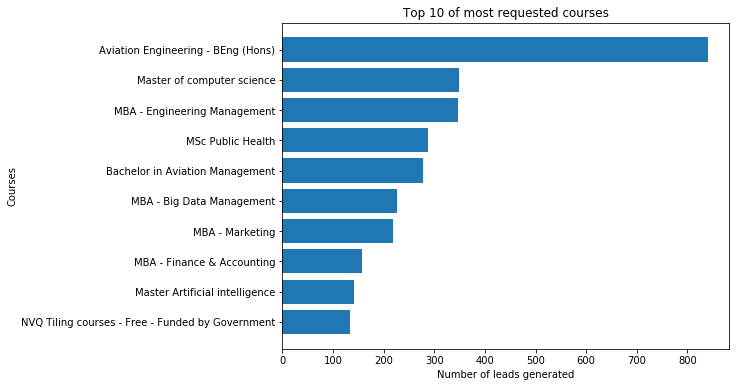

In [124]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_courses.index, top_courses.values)
ax.set_title('Top 10 of most requested courses')
ax.set_xlabel('Number of leads generated')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

### Top categories by number of leads generated

In [125]:
top_categories = leads_df.groupby('course_category').count().sort_values('user_id', ascending=False).head(10)['user_id']

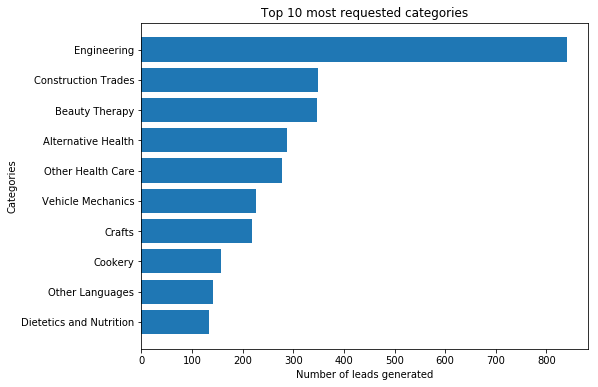

In [126]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_categories.index, top_courses.values)
ax.set_title('Top 10 most requested categories')
ax.set_xlabel('Number of leads generated')
ax.set_ylabel('Categories')
ax.invert_yaxis()
plt.show();

### Number of users that generates an amount of leads

In [127]:
counts = leads_df.groupby('user_id')['course_id'].count().values

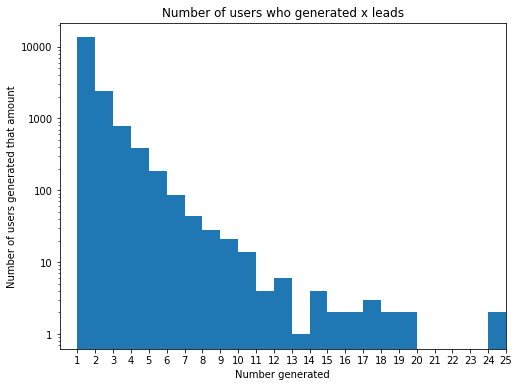

In [128]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(min(counts), max(counts) + 1)
plt.hist(counts, bins=bins)
ax.set_title('Number of users who generated x leads')
ax.set_xlabel('Number generated')
ax.set_ylabel('Number of users generated that amount')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlim(0, max(counts))
plt.xticks(np.arange(min(counts), max(counts) + 1, 1.0))

plt.show();

The trend is that each user generates few leads. We note that most users only generate a lead

### The most reviewed courses

In [129]:
top_reviewed_courses = reviews_df.groupby('course_title').count().sort_values('user_id', ascending=False).head(10)['user_id']

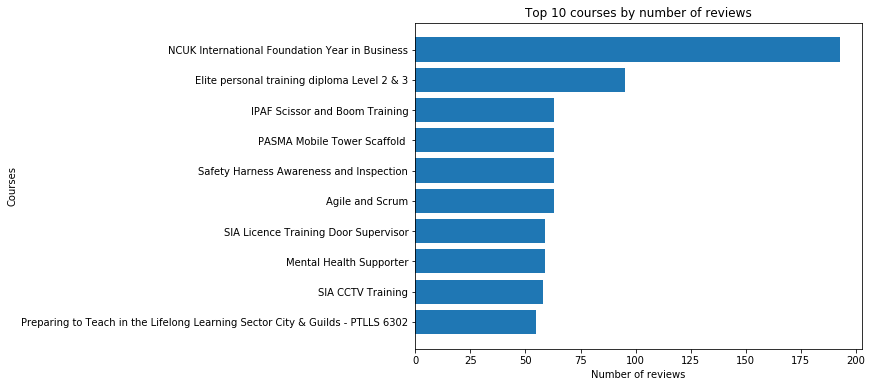

In [130]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_reviewed_courses.index, top_reviewed_courses.values)
ax.set_title('Top 10 courses by number of reviews')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

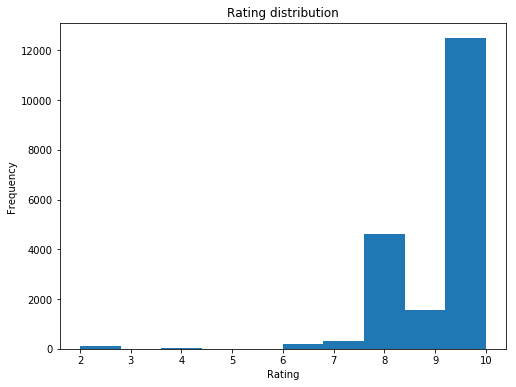

In [131]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(reviews_df['rating'])
ax.set_title('Rating distribution')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')

plt.show();

In [132]:
def get_courses_name(courses_ids):
    return all_courses_df.take(all_courses_df['course_id'][all_courses_df['course_id'].isin(courses_ids)].sort_values().index)

## II. Rank Based Recommendations

In this case there will be two rankings to create recommendations: a ranking of the most requested courses and a ranking of the most valued courses.

### The most popular courses

In [133]:
def get_top_courses_by_leads(df, n=10, category=None, titles=False):
    """ 
    Creates an array of n courses ordered by number of leads generated
    
    :param df DataFrame: Leads dataframe
    :param n int: Number of courses in the array
    :param category str: If category is supplied, the array will be of courses belonging to that category
    :param titles bool: If titles is True, the array will be of course names, 
        if False the array will be of course ids
    :return numpy.ndarray: Array of top n courses by leads generated
    """
    column = 'course_id'
    
    if titles:
        column = 'course_title'
        
    if category:
        df = df[df['course_category'] == category]
        
    top_courses = df.groupby(column).count()['user_id'].sort_values(ascending=False).iloc[:n]
    
    return top_courses.index.values

In [134]:
print(get_top_courses_by_leads(leads_df, category='Engineering', titles=True))

['Aviation Engineering - BEng (Hons)' 'Master of computer science'
 'MBA - Engineering Management' 'Master Artificial intelligence'
 'Master in Engineering Management' 'BTEC HND Civil Engineering'
 'Introduction to Basic TIG Welding'
 'Level 5 Diploma in Civil Engineering' 'B.TECH CIVIL ENGINEERING'
 'Mechanical Engineering - BEng (Hons) Scheme']


https://baymard.com/blog/sort-by-customer-ratings

https://stackoverflow.com/questions/1411199/what-is-a-better-way-to-sort-by-a-5-star-rating

### The most valued courses

In [135]:
def get_top_courses_by_rating(df, n=10, category=None, titles=False, weighted=True):
    """ 
    Creates an array of n courses ordered by rating
    
    :param df DataFrame: Reviews dataframe
    :param n int: Number of courses in the array
    :param category str: If category is supplied, the array will be of courses belonging to that category
    :param titles bool: If titles is True, the array will be of course names.
                        If False the array will be of course ids
    :param weighted bool: If True the array will be sorted by weighted rating average. 
                          If false the array will be sorted by rating average
                          
    :return numpy.ndarray: Array of top n courses by rating
    """
    return_column = 'course_id'
    sort_column = 'avg_rating'
    
    if titles:
        return_column = 'course_title'
        
    if weighted:
        sort_column = 'weighted_rating_average'
        
    if category:
        df = df[df['course_category'] == category]
    
    df = df.drop_duplicates('course_id')
    
    top_courses = df.sort_values(by=sort_column, ascending=False)
    
    return top_courses[return_column].values[:n]

In [136]:
get_top_courses_by_rating(reviews_df, category='Engineering')

array(['170575432', '170574416', '170582704', '170582700', '170560683',
       '170560663', '170560624', '170560594', '170314045', '170582706'],
      dtype=object)

## III. Neighborhood Based Collaborative Filtering

### User-item matrix
Loading the user-item matrices

In [137]:
ratings_user_item_matrix = pd.read_csv('../data/ratings_matrix.csv')
leads_user_item_matrix = pd.read_csv('../data/leads_matrix.csv')

In [138]:
ratings_user_item_matrix.set_index('user_id', inplace=True)
leads_user_item_matrix.set_index('user_id', inplace=True)

### User-courses interactions

Loading the user-course interactions dictionaries.

In [139]:
with open('../data/rated_courses.pickle', 'rb') as file:
    rated_courses = pickle.load(file)

with open('../data/generated_leads.pickle', 'rb') as file:
    generated_leads = pickle.load(file)

### Recommendations based on leads generated

In [140]:
def find_similar_users(user_id, user_item_matrix):
    """ 
    Creates an array of similar users based on leads generated on the same courses
    
    :param user_id str: User id for which we want to find similar users
    :param user_item_matrix DataFrame: Leads user-item matrix
                          
    :return numpy.array: Array of similar users sorted by similarity
    """
    
    user = np.array(user_item_matrix.loc[user_id])
    
    similarities = dict()
    
    for another_user_id, courses in user_item_matrix.iterrows():
        if user_id == another_user_id:
            continue
        
        similarities[another_user_id] = np.dot(user, np.array(courses))

    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    
    return np.array([id for (id, similarity) in sorted_similarities])


def get_user_leads(user_id):
    """ 
    Returns a list of courses to which the user has generated lead
    
    :param user_id str: User id for which we want to find generated leads
                          
    :return list: List of courses to which the user has generated lead
    """
    return generated_leads[user_id]

In [141]:
def leads_based_recommendations(user_id, max_recs=10):
    """ 
    Returns an array of recommended courses for a user based on generated leads
    
    :param user_id str: User id for which we want to make the recommendations
    :param max_recs int: Maximum number of recommendations
                          
    :return numpy.array: Array of courses recommended based on generated leads
    """
    
    user_courses = get_user_leads(user_id)
    similar_users = find_similar_users(user_id, leads_user_item_matrix)

    recs = np.array([])

    for user in similar_users:
        neighbs_leads = get_user_leads(user)

        new_recs = np.setdiff1d(neighbs_leads, user_courses, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

In [142]:
user_id = 'a943303554c76da95559fb67d39f8945'
leads_recommendations = leads_based_recommendations(user_id)

get_courses_name(leads_recommendations)

,course_id,title,center,category
28475,170032957,Complete Joinery,Merseyside Construction Training,DIY
27897,170140432,Open Water Diver,Aberdeen Watersports,Water Sports
2270,170493230,Massage Therapist Diploma,New Skills Academy,Other Health Care
1956,170562038,MBA Master of Business Administration in Oil a...,Middlesex University,Other Business Administration
2812,170565149,Financial Trading,International Open Academy,Financial Markets
12549,170612791,Diploma in hypnotherapy,John Academy,Alternative Health
6133,170613538,Post Graduate Diploma Industrial Health and Hy...,Global Institute of Health Science,Environmental Management
273,170613987,MSc Finance,The University of Aberdeen Business School Online,Accounting
95,170632737,Master of Science in Financial Analysis,ESSCA School of Management International,Accounting
5141,170641962,Professional Photographer Training,One Education,Photography


In [143]:
leads_df[leads_df['user_id'] == user_id]

,user_id,course_id,course_title,course_category,center,created_on
7637,a943303554c76da95559fb67d39f8945,170250292,Thai Foot Massage,Alternative Health,OASIS-TIME Beauty & Holistic Academy,2019-10-31 19:36:10
7646,a943303554c76da95559fb67d39f8945,170659401,"NAiLS IT! Course (Nail course for Nurses, HCAs...",Nursing,West London School of Beauty & Portsmouth Hair...,2019-10-31 19:13:23
7647,a943303554c76da95559fb67d39f8945,170074552,Manicure and Pedicure,Beauty Therapy,Nails and Beauty Academy,2019-10-31 19:09:04
7651,a943303554c76da95559fb67d39f8945,170377694,Manicure & Pedicure,Beauty Therapy,Butterfly Beauty Training School,2019-10-31 18:59:30


In [144]:
print(leads_recommendations)

['170032957' '170140432' '170493230' '170562038' '170565149' '170612791'
 '170613538' '170613987' '170632737' '170641962']


### Recommendations based on ratings

In [145]:
def find_closest_neighbors(user_id, distances):
    closest_users = distances[distances['a_user'] == user_id].sort_values(by='eucl_dist').iloc[1:]['another_user']
    
    return np.array(closest_users)

def courses_liked(user_id, df, min_rating=7):
    courses_liked = df[(df['user_id'] == user_id) & (df['rating'] >= min_rating)]['course_id']
    
    return np.array(courses_liked)
    
def rating_based_recommendations(user_id, users_distances, max_recs=10):
    user_courses = ratings_user_item_matrix.loc[user_id]
    user_courses = user_courses[user_courses.notnull()].index.values
        
    closest_neighbors = find_closest_neighbors(user_id, users_distances)
    
    recs = np.array([])
    
    for neighbor in closest_neighbors:
        neighb_likes = courses_liked(neighbor, reviews_df)
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighb_likes, user_courses, assume_unique=True)

        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        # If we have enough recommendations exit the loop
        if len(recs) > max_recs - 1:
            break
    
    return recs

In [146]:
with open('../data/users_distances.pickle', 'rb') as file:
    users_distances = pickle.load(file)

In [147]:
users_distances['eucl_dist'].value_counts()

0.000000    14
4.000000     4
2.828427     2
5.656854     2
Name: eucl_dist, dtype: int64

In [151]:
user_id = 'a943303554c76da95559fb67d39f8945'
rating_recommendations = rating_based_recommendations(user_id, users_distances)

In [152]:
reviews_df[reviews_df['user_id'] == user_id]

,user_id,course_id,course_title,course_category,center,rating,created_on,avg_rating,num_reviews,weighted_rating_average
356,a943303554c76da95559fb67d39f8945,170447290,Foot-reflex Assessment & Massage,Alternative Health,The S.E.E.D. Institute,2,2019-11-30 08:41:25,2.0,1,9.118406
357,a943303554c76da95559fb67d39f8945,170074552,Manicure and Pedicure,Beauty Therapy,Nails and Beauty Academy,2,2019-11-30 08:38:30,2.0,1,9.118406
358,a943303554c76da95559fb67d39f8945,170377698,Nail Art,Beauty Therapy,Butterfly Beauty Training School,2,2019-11-30 08:37:52,2.0,1,9.118406
359,a943303554c76da95559fb67d39f8945,170377694,Manicure & Pedicure,Beauty Therapy,Butterfly Beauty Training School,2,2019-11-30 08:37:02,2.0,1,9.118406
409,a943303554c76da95559fb67d39f8945,170615406,Beauty Therapy : Manicure and Pedicure,Beauty Therapy,CPD Courses,2,2019-11-23 22:58:17,2.0,1,9.118406
462,a943303554c76da95559fb67d39f8945,170250292,Thai Foot Massage,Alternative Health,OASIS-TIME Beauty & Holistic Academy,2,2019-11-19 07:24:19,2.0,1,9.118406
463,a943303554c76da95559fb67d39f8945,170172972,Korean hand massage & Mongolian koyashai foot ...,Alternative Health,Ayushi Holistic,2,2019-11-19 07:17:18,2.0,1,9.118406


In [153]:
get_courses_name(rating_recommendations)

,course_id,title,center,category


Nothing to recommend. As we have seen before, the vast majority of users rate a single course. This makes it very difficult to find matches between users. In fact, the `users_distances` dataframe has only 22 rows.

In [154]:
users_distances.shape

(22, 3)

For our collaborative filtering based recommendations, the lead generated by the user in the course is much more valuable than its assessment of it. So I will use the raitings only for the rank based recommendation system. In that type of recommendation system, ratings are extremely useful.

## IV. Content Based Recommendations

In [164]:
courses_similarities = pd.read_csv('../data/courses_similarities.csv', 
                                   dtype={'a_course': str, 'another_course': str})

In [173]:
courses_similarities.head(20)

,a_course,another_course,similarity
0,170648149,170648146,0.996332
1,170648149,170652710,0.505740
2,170367782,170642187,0.539035
3,170367782,170624005,0.557652
4,170601656,170617492,0.500261
5,170628400,170628401,0.699286
6,170628400,170628423,0.526044
7,170628400,170642641,0.567153
8,170628400,170642682,0.533256
9,170628400,170628402,0.599312


In [166]:
def similar_courses(course_id, df):
    courses = df[df['a_course'] == course_id].sort_values('similarity', ascending=False)['another_course'].values
    
    return np.array(courses)

In [175]:
course_id = '170628400'

get_courses_name([course_id])

,course_id,title,center,category
5,170628400,MCSA: SQL Server 2016 - Database Administration,Training Square,SQL Server


In [176]:
get_courses_name(similar_courses(course_id, courses_similarities))

,course_id,title,center,category
25,170628401,MCSA: SQL Server 2016 - Database Development,Training Square,SQL Server
1319,170628402,MCSA: SQL Server 2012 Data Platform,Training Square,SQL Server
1145,170628423,MCSA: SQL Server 2016 Database Administration,London Training Group LTD,SQL Server
1184,170642641,MCSA Certification Bundle With 2 Exams: SQL 20...,Hudson Courses Limited,IT Systems
1239,170642682,SQL for Beginners (Exams Included),Hudson Courses Limited,SQL Server
4938,170649137,Whats New in SQL Server 2016,Acuity Training London,SQL Server
10812,170654677,MCSA SQL 2016 DATABASE ADMINISTRATION,IT Online Learning,SQL Server
4364,170656706,MCSA Certification Bundle With 2 Exams: SQL 20...,Hudson Courses Limited,SQL Server


## V. Model Based Collaborative Filtering
In this part I will use the leads user-item matrix. Since there are no nan values in that matrix, I can use Singular Value Decomposition from numpy on the matrix.

### Perform SVD

In [177]:
u, s, vt = np.linalg.svd(leads_user_item_matrix)

In [178]:
s.shape, u.shape, vt.shape

((8243,), (17417, 17417), (8243, 8243))

In the following graph we will see how the accuracy improves as we increase the number of lantent features

In [223]:
def reduce_svd(k):
    U_reduced = np.mat(u[:,:k])
    Vt_reduced = np.mat(vt[:k,:])
    Sigma_reduced = np.eye(k) * s[:k]

    return Sigma_reduced, U_reduced, Vt_reduced

def reduce_svd_2(k):
    U_reduced = np.mat(u[:,:k])
    Vt_reduced = np.mat(vt[:k,:])
    Sigma_reduced = np.eye(k) * s[:k]
    Sigma_sqrt = np.sqrt(Sigma_reduced)

    return U_reduced * Sigma_sqrt, Sigma_sqrt * Vt_reduced

In [182]:
num_latent_feats = np.arange(10,1500,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(leads_user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

NameError: name 'df' is not defined

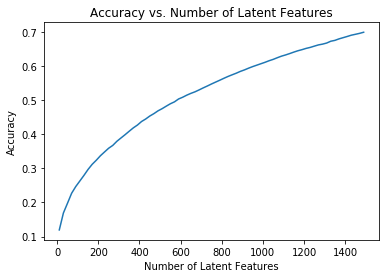

In [183]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/leads_df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [186]:
leads_df.shape

(24908, 6)

In [187]:
leads_df.head()

,user_id,course_id,course_title,course_category,center,created_on
0,faf61312a2da38d95051130f9a9162f2,170641938,Level 3 Diploma in Counselling and Psychotherapy,Counselling,One Education,2019-12-08 18:50:22
1,0fea90bc02208acef1ed8d68ff87fa64,170660881,MBA - Finance & Accounting,Accounting,IUBH Online,2019-12-08 18:47:12
2,08515f84f44d7a52fa053ee8918952f6,170663641,Master of computer science,Engineering,IUBH Online,2019-12-08 18:30:52
3,fdc6ae1b37c9a3b5855f981cbd5aca84,170439892,Carpentry Apprenticeship,Construction Trades,Birmingham Metropolitan College,2019-12-08 18:24:45
4,3125ddd787800a6b45f71f722089421c,170641213,Personal Leadership and Success,Leadership,Columbia Business School Executive Education,2019-12-08 18:22:52


In [188]:
leads_user_item_matrix.head()

,170000281,170000671,170001277,170001299,170001307,170001782,170002478,170002752,170002758,170002759,...,170664041,170664049,170664115,170664144,170664394,170664402,2365326,2365342,2365345,2365419
user_id,,,,,,,,,,,,,,,,,,,,,
0000b20311e912f825aadd5bd195d9d4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00051809e2bdb1c043e31c8f1fab3db3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000636998bb2ddc24f1cea51ad14c70b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0019e8001638e876a798996ddd68307e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001d7fed950bc1f5834b2d4af75b1879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
leads_df.sort_values('created_on').head()

,user_id,course_id,course_title,course_category,center,created_on
24907,acf8bfc88dc5d693d0211e3eddaf56ab,170654454,Video Tutorial FDKM Full Program Krav Maga Isr...,Martial Arts,FDKM ISRAELI JU-JITSU / KRAV MAGA,2019-07-26 19:07:13
24906,3e7638adad7c864f986a4afeb24b8625,170265926,Part Time Sign Language Level One Unit 102,Other Languages,Telford College Of Arts and Technology,2019-07-26 19:32:55
24905,ce4deba5f105de3adec953cbe13260dc,170471798,ABC Level 2 Award in Counselling Skills Part-time,Counselling,Warwickshire College,2019-07-26 20:19:51
24904,983160478470a9b0528923bc9753c1b8,170564733,Nail Technician Course - Level 3 - Accredited,Beauty Therapy,Oplex careers,2019-07-26 20:40:43
24903,8f75b9fe635153769444b224f18765f3,170605143,Introduction to Barbering Short Course,Beauty Therapy,St Helens College,2019-07-26 20:52:08


In [228]:
def create_user_item_matrix(df, group_columns=['user_id', 'course_id'], select_column='rating', allow_nulls=True):
    """
    Creates a user-item matrix DataFrame. Depending on the dataframe supplied it creates a
    user-item matrix from reviews of from leads
    
    :param group_columns list: Columns by which the data will be grouped
    :param select_column str: 
    :param allow_nulls bool: 
    
    :return DataFrame: a user-item matrix dataframe
    """
    columns = [column for column in group_columns]
    columns.extend([select_column])
    
    user_items = df[columns]
    
    user_by_course = user_items.groupby(group_columns)[select_column].max().unstack()
    
    if not allow_nulls:
        user_by_course = user_by_course.where(user_by_course.isnull(), other=1)
        user_by_course = user_by_course.fillna(0)
    
    return user_by_course

In [246]:
def train_test_split(df, order_by, total_size=None, train_size=.8, test_size=.2):
    df_size = df.shape[0] if total_size is None else total_size
    train_size = int(np.floor(df_size * train_size))
    test_size = int(np.floor(df_size * test_size))
    
    #df = df.sort_values(order_by)
    train_set = df.head(train_size)
    #test_set = df.iloc[train_size:train_size + test_size]
    test_set = df.tail(test_size)
    
    return train_set, test_set

In [256]:
train_df, test_df = train_test_split(leads_df, 'created_on')

In [257]:
train_user_item_matrix = create_user_item_matrix(train_df, select_column='course_title', allow_nulls=False)
test_user_item_matrix = create_user_item_matrix(test_df, select_column='course_title', allow_nulls=False)

In [258]:
train_idx = train_user_item_matrix.index.values
train_courses = train_user_item_matrix.columns.values
test_idx = test_user_item_matrix.index.values
test_courses = test_user_item_matrix.columns.values

n_users_preds = len(np.intersect1d(test_idx, train_idx))
cold_start_users = len(test_idx) - n_users_preds

n_courses_preds = len(np.intersect1d(test_courses, train_courses))
cold_start_courses = len(test_courses) - n_courses_preds

print('Users we can make predictions for: {}\n' \
      'Users we cannot make predictions for: {}\n' \
      'Courses we can make predictions for: {}\n' \
      'Courses we cannot make predictions for: {}\n'.format(n_users_preds, cold_start_users, n_courses_preds, cold_start_courses))

Users we can make predictions for: 95
Users we cannot make predictions for: 3401
Courses we can make predictions for: 1622
Courses we cannot make predictions for: 1347



In [259]:
def predictions(u, s, vt, k):
    '''
    INPUT:
    u - user feature matrix
    s - test dataframe
    vt - item feature matrix
    k - number of latent features to keep
    
    OUTPUT:
    user_item_matrix - a predictions user-item matrix
    
    '''
    
    s_new = np.diag(s[:k])
    u_new = u[:, :k]
    vt_new = vt[:k, :]
    
    user_item_matrix = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    return user_item_matrix

In [260]:
u_train, s_train, vt_train = np.linalg.svd(train_user_item_matrix)
u_train.shape, s_train.shape, vt_train.shape

((14016, 14016), (6895,), (6895, 6895))

In [261]:
common_user_ids = train_user_item_matrix.index.isin(test_idx)
common_courses_ids = train_user_item_matrix.columns.isin(test_courses)

u_test = u_train[common_user_ids, :]
vt_test = vt_train[:, common_courses_ids]

u_test.shape, vt_test.shape

((95, 14016), (6895, 1622))

In [270]:
test_user_item_matrix = test_user_item_matrix.loc[np.intersect1d(test_idx, train_idx), np.intersect1d(test_courses, train_courses)]

In [297]:
num_latent_feats = np.arange(5,800,10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    user_train_preds = predictions(u_train, s_train, vt_train, k)
    user_test_preds = predictions(u_test, s_train, vt_test, k)
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(train_user_item_matrix, user_train_preds)
    diffs_test = np.subtract(test_user_item_matrix, user_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

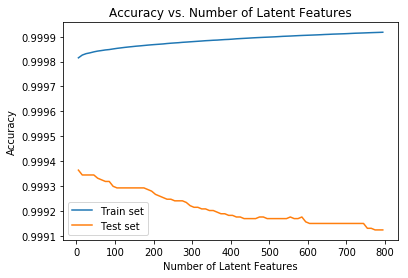

In [298]:
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_train)/(train_user_item_matrix.shape[0]*train_user_item_matrix.shape[1])), label='Train set');
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_test)/(test_user_item_matrix.shape[0]*test_user_item_matrix.shape[1])), label='Test set');

plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

In [224]:
k = 10

u_new, vt_new = reduce_svd_2(1000)
    
# take dot product
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

m_hat_df = u_new * vt_new

In [227]:
u_new[1] * vt_new[:, 2]

matrix([[-1.07409121e-17]])

In [273]:
u_train.shape, s_train.shape, vt_train.shape

((14016, 14016), (6895,), (6895, 6895))

In [274]:
m_hat = predictions(u_train, s_train, vt_train, 1300)

In [277]:
m_hat.shape

(14016, 6895)

In [278]:
train_user_item_matrix.shape

(14016, 6895)

In [279]:
m_hat_df = pd.DataFrame(m_hat, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

In [293]:
m_hat_df.tail()

course_id,170000281,170001277,170001299,170001307,170001782,170002752,170002758,170002759,170002760,170002868,...,170664041,170664049,170664115,170664144,170664394,170664402,2365326,2365342,2365345,2365419
user_id,,,,,,,,,,,,,,,,,,,,,
ffe8d7148b11c51d7ec1455ff1ed7c39,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
ffeb48c8895999888aae069a8e9cd1d1,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
ffeeadfdbe4961746fb2c22361d2eb5b,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
fff1f7f46152e282f2d686cf536bab9d,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
fffa4eab809838533c942913b33802d2,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0


In [294]:
m_hat_df.loc['ffeeadfdbe4961746fb2c22361d2eb5b'].sum()

1.0

In [288]:
test_user_item_matrix.loc['09ff98d9888e78c006ca2e6e2534537b']['170005960']

0

In [285]:
test_user_item_matrix.head()

course_id,170001277,170001299,170001307,170002760,170003629,170005635,170005637,170005670,170005960,170005970,...,170659592,170659593,170659594,170659596,170659597,170659598,170659600,170659601,2365342,2365419
user_id,,,,,,,,,,,,,,,,,,,,,
066a1f30f4888ef0f5cb951c9a158778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
07bfb53e32248adf486f5328aadd15e3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
07c526efdbf70eaa3d872976635b0bf5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
09ff98d9888e78c006ca2e6e2534537b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0a15257ae7f2f7712d61abd7c6d70445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [289]:
'2BAACF49018E7FBB39442762C07FCBDC'.lower()

'2baacf49018e7fbb39442762c07fcbdc'

In [299]:
k = 10

s_new = np.diag(s_train[:k])
u_new = u_train[:, :k]
vt_new = vt_train[:k, :]
new = np.zeros(train_user_item_matrix.shape[1], dtype=np.int8)

In [300]:
new

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [301]:
new[0] = 1

In [302]:
new

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

In [316]:
new * vt_new.T * np.linalg.inv(s_new)

ValueError: operands could not be broadcast together with shapes (6895,) (6895,10) 

In [310]:
np.around(np.dot(np.dot(new, s_new), vt_new))

ValueError: shapes (6895,) and (10,10) not aligned: 6895 (dim 0) != 10 (dim 0)